##Reading the text file, creating pandas dataframe and displaying the data

In [ ]:
import pandas as pd
import numpy as np
from io import open
from google.colab import drive
drive.mount('/content/drive')

!pwd
path = 'drive/MyDrive/Amazon_dataset/Cell_Phones_&_Accessories.txt'

with open(path, "rb") as f:

    data = []
    record = []
    keys = []

    #Extract data from the file
    contents = f.read().decode("UTF-8")

    lines = contents.splitlines()

    for index, line in enumerate(lines):
      if ": " in line:
        #Split into key, value pairs
        key_value = line.strip().split(": ", 1)
        if len(key_value) > 1:
          [key, value] = key_value
          record.append(value)
          if key not in keys:
            keys.append(key)
        else:
          #Missing value
          record.append(None)
      else:
        #Next data sample
        data.append(record)
        record = []

dat = np.array(data)
data_dict = dict(zip(keys, dat.T))
df = pd.DataFrame.from_dict(data_dict)
print(f"Number of records: {dat.shape[0]}")
df.head()

Mounted at /content/drive
/content
Number of records: 78930


,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A1RXYH9ROBAKEZ,A. Igoe,0/0,1.0,1233360000,Don't buy!,"First of all, the company took my money and se..."
1,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A7L6E1KSJTAJ6,Steven Martz,0/0,5.0,1191456000,Mobile Action Bluetooth Mobile Phone Tool Soft...,Great product- tried others and this is a ten ...
2,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A2NOQQ7I6PU7CW,"Daniel M. Johnson ""rocknbluesharp""",0/0,4.0,1186704000,good,works real good....a little hard to set up...w...
3,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,A29Q0CLOF0U8BN,E. Owens,4/5,4.0,1146182400,No instructions included...,The price was right for this cable ($11.95+$4....
4,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,ANNHJND2MHUI3,"Isaac Salas ""=CRBF=gB^link""",0/0,1.0,1173657600,NOT A DATA CABLE,this is NOT a DATA CABLE this is only a USB ch...


##Renaming the columns, converting the time, changing missing values to NaN, counting up missing values 

In [ ]:
from datetime import datetime

df = df.rename(columns={"product/productId": "productId", "product/title": "title", "product/price": "price", "review/userId": "userId", "review/profileName": "userName", "review/helpfulness": "helpfulness",\
                  "review/score": "stars", "review/time": "time", "review/summary": "summary", "review/text": "text"})

df['stars'] = df['stars'].astype(float).astype(int)
df['time'] = [datetime.fromtimestamp(int(x)) for x in df['time']]
df = df.replace('unknown', np.nan)
print(df.isnull().sum())
df.head()

df.to_csv('data.csv')


productId          0
title            547
price          43287
userId          2276
userName        2276
helpfulness        0
stars              0
time               0
summary            2
text               0
dtype: int64


##Detecting language of the reviews using FastText
language identification model based on character patterns - https://fasttext.cc/docs/en/language-identification.html

In [ ]:
!pip install fasttext

import fasttext
import matplotlib.pyplot as plt

ft_model = fasttext.load_model('drive/MyDrive/RECRUITMENT/lid.176.bin')

example = df['text'][0]
#print(print(f"Sample output {ft_model.predict(example)}"))

df['predicted_lang'] = None
strings = df['text'].str.lower()

ft_outputs = strings.apply(lambda x: ft_model.predict(x) if x else None)
df['predicted_lang'] = [x[0][0][9:] if x and x[1][0] > 0.85 else None for x in ft_outputs]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp39-cp39-linux_x86_64.whl size=4395641 sha256=452b51ce093981b80eab21f5a3c9b46e49330f04cb0d1fab5e9e03049c5e586a
  Stored in directory: /root/.cache/pip/wheels/64/57/bc/1741406019061d5664914b070bd3e71f6244648732bc96109e
Successfully built fasttext


##Language statistics

In [ ]:
print("Language statistics")
print(df['predicted_lang'].value_counts(dropna=False))
print()
print("Examples")
print(f"en - {df.loc[df['predicted_lang'] == 'en', 'text'].iloc[0]}")
print(f"en - {df.loc[df['predicted_lang'] == 'en', 'text'].iloc[1]}")
print(f"es - {df.loc[df['predicted_lang'] == 'es', 'text'].iloc[0]}")
print(f"es - {df.loc[df['predicted_lang'] == 'es', 'text'].iloc[1]}")
print(f"pt - {df.loc[df['predicted_lang'] == 'pt', 'text'].iloc[0]}")
print(f"pt - {df.loc[df['predicted_lang'] == 'pt', 'text'].iloc[1]}")
print(f"fr - {df.loc[df['predicted_lang'] == 'fr', 'text'].iloc[0]}")
print(f"None - {df.loc[df['predicted_lang'].isnull(), 'text'].iloc[0]}")
print(f"None - {df.loc[df['predicted_lang'].isnull(), 'text'].iloc[1]}")

Language statistics
en      78104
None      703
es        120
pt          2
fr          1
Name: predicted_lang, dtype: int64

Examples
en - First of all, the company took my money and sent me an email telling me the product was shipped. A week and a half later I received another email telling me that they are sorry, but they don't actually have any of these items, and if I received an email telling me it has shipped, it was a mistake.When I finally got my money back, I went through another company to buy the product and it won't work with my phone, even though it depicts that it will. I have sent numerous emails to the company - I can't actually find a phone number on their website - and I still have not gotten any kind of response. What kind of customer service is that? No one will help me with this problem. My advice - don't waste your money!
en - Great product- tried others and this is a ten compared to them. Real easy to use and sync's easily. Definite recommended buy to transfer d

##Score analysis

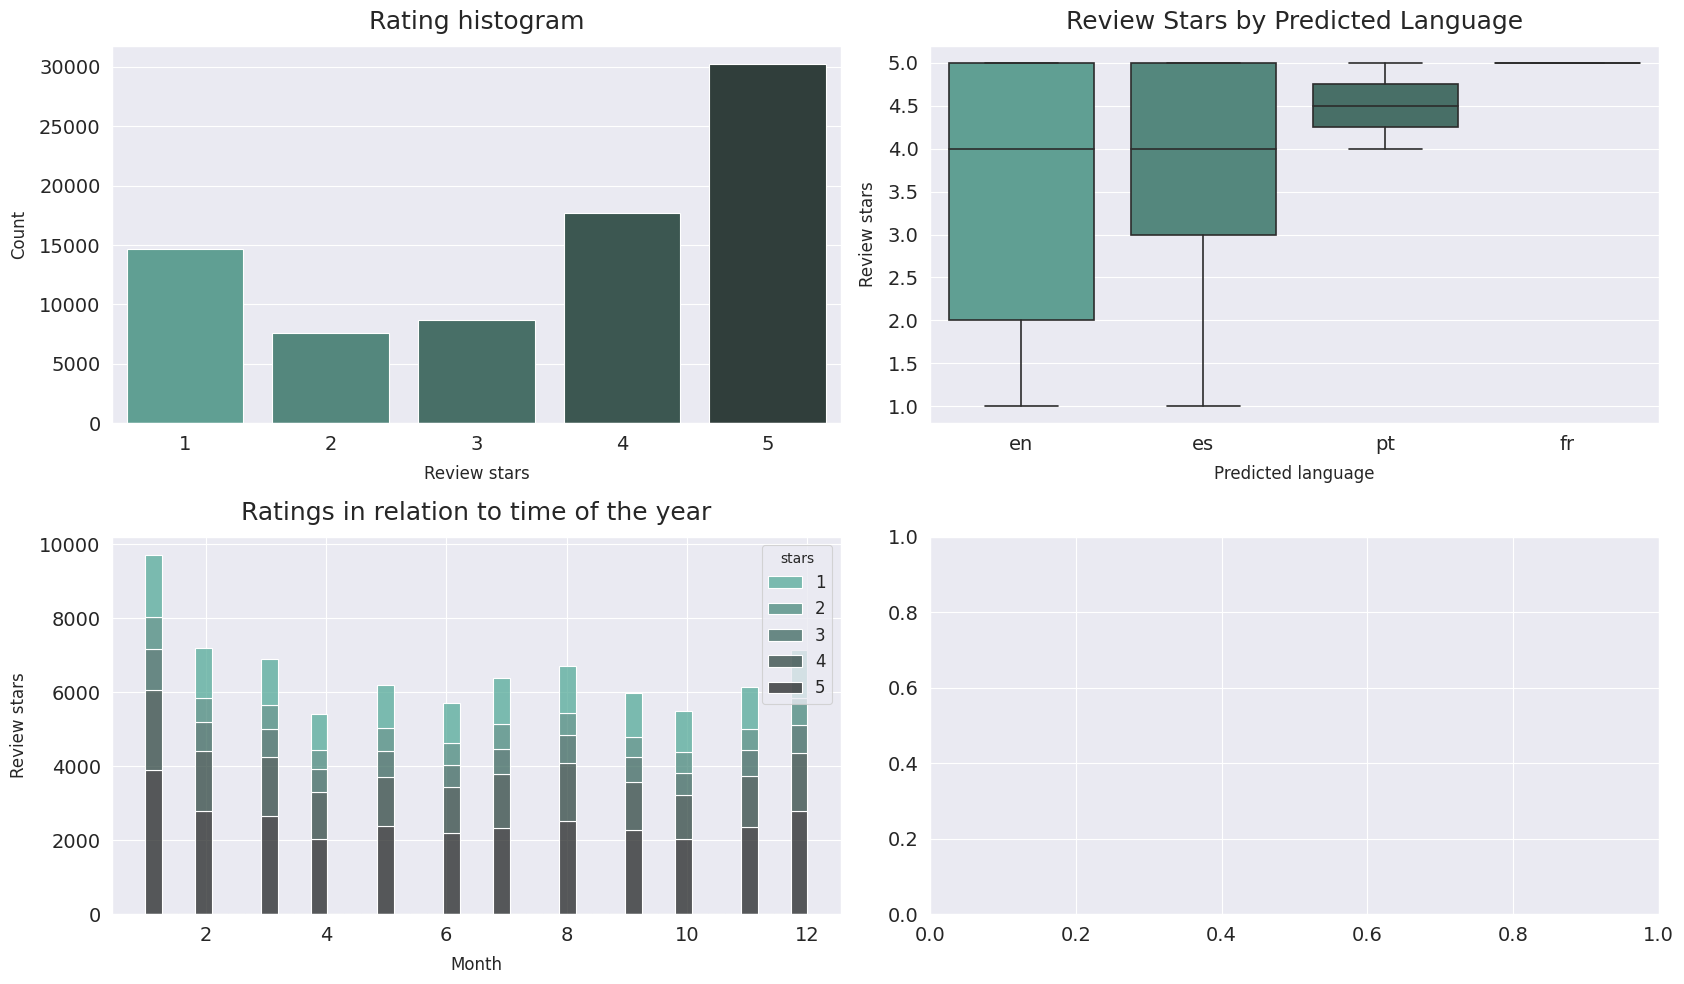

In [ ]:
#!pip install -U seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set(rc={'figure.figsize':(17,10), 'font.size':12, 'axes.titlesize':18, 'axes.labelsize':12,\
            'xtick.labelsize':14, 'ytick.labelsize':14, 'legend.fontsize':12, 'legend.title_fontsize':10,\
            'axes.titlepad':12, 'axes.labelpad':8}, palette='dark:#5A9_r', context='paper', style='darkgrid')

fig, axs = plt.subplots(nrows=2, ncols=2)

ax = sns.countplot(data=df, x='stars', ax = axs[0][0])
ax.set_xlabel('Review stars')
ax.set_ylabel('Count')
ax.set_title('Rating histogram')


ax2 = sns.boxplot(data=df, x='predicted_lang', y='stars', ax=axs[0,1])
ax2.set_xlabel('Predicted language')
ax2.set_ylabel('Review stars')
ax2.set_title('Review Stars by Predicted Language')

df['months'] = df['time'].dt.month
ax3 = sns.histplot(data=df, x='months', hue='stars', multiple='stack',ax=axs[1,0], palette='dark:#5A9_r')
ax3.set_xlabel('Month')
ax3.set_ylabel('Review stars')
ax3.set_title('Ratings in relation to time of the year')
ax3.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
df.drop('months', axis=1, inplace = True)

plt.tight_layout()
plt.show()


- The majority of ratings are 1 and 5 stars.
- Q1 for Spanish speakers was higher than for English speakers
- Most reviews happen in December and January (Christmas period)


<Axes: xlabel='productId'>

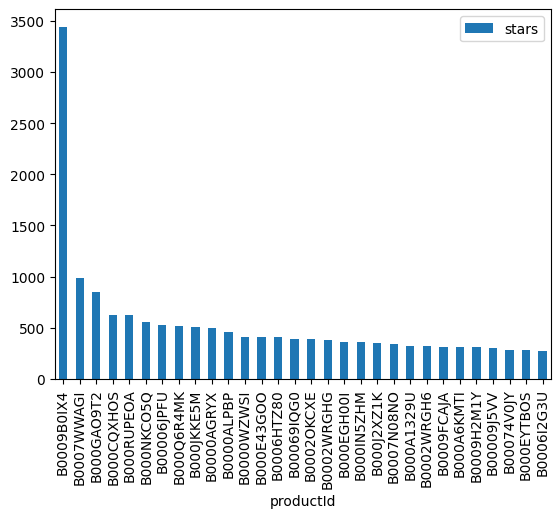

In [ ]:
popular_products = pd.DataFrame(df.groupby('productId')['stars'].count())
most_popular = popular_products.sort_values('stars', ascending=False)
most_popular.head(30).plot(kind = "bar")

#most_popular.head(30)
#df.groupby('productId')['stars'].mean().sort_values(ascending=False).head()

## SENTIMENT DETECTION

TIn this example I will test two fine-tunned models of BERT (https://huggingface.co/docs/transformers/model_doc/bert) available on Huggingface and trained for sentiment detection. The models were fine-tunned on product reviews and will output predicted rating (1-5).

Next I will fine-tune my own model using DestilBert.

##Analizing available models

In [ ]:
#!pip install transformers
import torch
print(torch.cuda.is_available())
from transformers import pipeline
from sklearn.metrics import classification_report, mean_squared_error


examples = ["It's not as good as other phones, but for this price it will do.", 
            "Other phones I had were terrible, but this one is the best",
            "It looks ugly to me, but my wife likes it",
            "Keeps disconnecting when my phone is in my pocket",
            "Szkoda pieniedzy na takie badziewie",
            "Kiedys byly lepsze",
            "sehr schlecht",
            "No quiero usarlo nunca en mi vida"
            ]


test_model = pipeline(model="nlptown/bert-base-multilingual-uncased-sentiment")

for sentence in examples:
  print(test_model(sentence), sentence)
print('------------------------')
ratings = {
    '1 star': 1,
    '2 stars': 2,
    '3 stars': 3,
    '4 stars': 4,
    '5 stars': 5}

def get_rating(output):
  return [ratings[answer['label']] for answer in output]

test_models = [
    "nlptown/bert-base-multilingual-uncased-sentiment",
    "LiYuan/amazon-review-sentiment-analysis"
]

tokenizer_kwargs = {'truncation':True}
n_examples = 200

for test_model in test_models:
  print(test_model)
  model = pipeline(model=test_model)
  ans = get_rating(model(df['text'].head(n_examples).tolist(), **tokenizer_kwargs))
  print(classification_report(df['stars'].head(n_examples).tolist(), ans))
  print(f"MSE: {mean_squared_error(df['stars'].head(n_examples).tolist(), ans)}")


True
[{'label': '3 stars', 'score': 0.5150371789932251}] It's not as good as other phones, but for this price it will do.
[{'label': '5 stars', 'score': 0.5644564628601074}] Other phones I had were terrible, but this one is the best
[{'label': '3 stars', 'score': 0.5493702292442322}] It looks ugly to me, but my wife likes it
[{'label': '2 stars', 'score': 0.3146359920501709}] Keeps disconnecting when my phone is in my pocket
[{'label': '1 star', 'score': 0.28984540700912476}] Szkoda pieniedzy na takie badziewie
[{'label': '3 stars', 'score': 0.35881179571151733}] Kiedys byly lepsze
[{'label': '1 star', 'score': 0.7649973034858704}] sehr schlecht
[{'label': '1 star', 'score': 0.5910858511924744}] No quiero usarlo nunca en mi vida
------------------------
nlptown/bert-base-multilingual-uncased-sentiment
              precision    recall  f1-score   support

           1       0.88      0.68      0.77        41
           2       0.26      0.56      0.36        16
           3       0.31 

- Only 200 examples were used for validation
- Model trained on amazon reviews achieved slightly higher accuracy. 
- It has correctly classified more reviews with 1 and 5 stars. 
- It performed slightly worse with reviews labeled with 3 and 4 stars. It had a tendency to predict 5 and 1 stars more often
- The second model is biased towards predicting 1 and 5 stars. In many datasets reviews with 1 and 5 stars tend to appear more often.

##Balanced dataset

In [ ]:
counts = df['stars'].value_counts()

sets = [None]*5

for i in range(5):
  sets[i] = df[df['stars']==i+1]
  sets[i] = sets[i].sample(n=50, random_state = 50)

balanced_set = pd.concat([sets[0], sets[1], sets[2], sets[3], sets[4]], axis=0)
balanced_set = balanced_set.sample(frac=1, random_state=50)


In [ ]:
for test_model in test_models:
  print(test_model)
  model = pipeline(model=test_model)
  ans = get_rating(model(balanced_set['text'].tolist(), **tokenizer_kwargs))
  print(classification_report(balanced_set['stars'].tolist(), ans))
  print(f"MSE: {mean_squared_error(balanced_set['stars'].tolist(), ans)}")

nlptown/bert-base-multilingual-uncased-sentiment
              precision    recall  f1-score   support

           1       0.65      0.60      0.63        50
           2       0.43      0.48      0.45        50
           3       0.51      0.54      0.52        50
           4       0.50      0.46      0.48        50
           5       0.63      0.62      0.63        50

    accuracy                           0.54       250
   macro avg       0.54      0.54      0.54       250
weighted avg       0.54      0.54      0.54       250

MSE: 0.84
LiYuan/amazon-review-sentiment-analysis
              precision    recall  f1-score   support

           1       0.60      0.74      0.66        50
           2       0.57      0.32      0.41        50
           3       0.57      0.42      0.48        50
           4       0.45      0.34      0.39        50
           5       0.55      0.94      0.70        50

    accuracy                           0.55       250
   macro avg       0.55      0.5

##Fine-tune destil-Bert.

In [ ]:
#!pip install transformers
#!pip install datasets
#!pip install evaluate
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from datasets import Dataset
from transformers import TrainingArguments, Trainer
import evaluate
from sklearn.metrics import accuracy_score, precision_score, recall_score

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
set = df[['text', 'stars']].sample(20000, random_state = 7)
set['stars'] = set['stars'] -1
set = set.rename(columns={'stars': 'labels'})
train, test = train_test_split(set, test_size = 0.2)

print(train.head())

train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)

print(f"Shape of training set: {train_dataset.shape}")
print(f"Shape of testing set {test_dataset.shape}")

def preprocess_function(examples):
  return tokenizer(examples["text"], truncation=True)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

import numpy as np
from datasets import load_metric
 
def compute_metrics(eval_pred):
   load_accuracy = evaluate.load("accuracy", average='macro')
   load_recall = evaluate.load("recall", average=None)
   load_precision = evaluate.load("precision", average=None)
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   precision = load_precision.compute(predictions=predictions, references=labels, average=None)["precision"]
   recall = load_recall.compute(predictions=predictions, references=labels, average=None)["recall"]
   return {"accuracy": accuracy, "precision": precision, "recall": recall}

from transformers import TrainingArguments, Trainer
 
repo_name = "Amazon-cell-phones-and-accessories"
 
training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=False,
)
 
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

trainer.train()
print(trainer.evaluate())
trainer.save_model('drive/MyDrive/RECRUITMENT/trained_model')



                                                    text  labels
66726  I bought one of these. It does not work. So fa...       0
35984  I was very unhappy with the phone. It did not ...       0
62535  I have a tendency to drop things, and this giv...       4
72323  THESE HELP GIVE A LITTLE MORE RECEPTION, BUT N...       2
68603  Loved and still loves this! But don't expect t...       4
Shape of training set: (16000, 3)
Shape of testing set (4000, 3)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Step,Training Loss
500,1.090500
1000,0.936300
1500,0.792700
2000,0.777100


Trainer is attempting to log a value of "[0.69549763 0.42413793 0.38329238 0.55189255 0.76768293]" of type <class 'numpy.ndarray'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.80742779 0.31060606 0.38423645 0.49615807 0.80705128]" of type <class 'numpy.ndarray'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.8602718710899353, 'eval_accuracy': 0.64425, 'eval_precision': array([0.69549763, 0.42413793, 0.38329238, 0.55189255, 0.76768293]), 'eval_recall': array([0.80742779, 0.31060606, 0.38423645, 0.49615807, 0.80705128]), 'eval_runtime': 55.7492, 'eval_samples_per_second': 71.75, 'eval_steps_per_second': 4.484, 'epoch': 2.0}


- # The model received higher accuracy (0.64) than previous models. It was trained on only 20 000 examples. The training was performed with an unbalanced set. Similiary to previous models it obtained high recall values for 1 and 5 stars classes.

- loss: 0.8602718710899353
- aaccuracy: 0.64425
- precision: array([0.69549763, 0.42413793, 0.38329238, 0.55189255, 0.76768293])
- eval_recall: array([0.80742779, 0.31060606, 0.38423645, 0.49615807, 0.80705128])

## Product recommender

### First method

In [ ]:
import numpy as np


#Correlation matrix
cor_mat = df[0:50000].pivot_table(index='productId', columns = 'userId', values='stars')
#print(cor_mat.head())

#Calculate Bayesian average
user_cols = []
for col in cor_mat.columns.values:
        user_cols.append(col)

cor_mat['v'] = cor_mat[user_cols].count(axis=1)
m = np.mean(cor_mat['v'])
cor_mat['w'] = cor_mat['v']/(cor_mat['v'] + m)
cor_mat['R'] = np.mean(cor_mat[user_cols], axis=1)
C = np.nanmean(cor_mat[user_cols].values.flatten())
cor_mat['S'] = cor_mat['w']*cor_mat['R'] + (1 - cor_mat['w'])*C

ratings = cor_mat['S']
cor_mat = cor_mat.drop(columns=['v', 'w', 'R', 'S'])
print(ratings.sort_values(ascending=False).head())



productId
B000IUYY2W    4.465398
B000BX7Q1C    4.426186
B000FHBEFS    4.359678
B0006FUHSE    4.356570
B000IVDI4Q    4.353130
Name: S, dtype: float64


productId
B000IUYY2W    4.465398
B000BX7Q1C    4.426186
B000FHBEFS    4.359678
B0006FUHSE    4.356570
B000IVDI4Q    4.353130
Name: S, dtype: float64


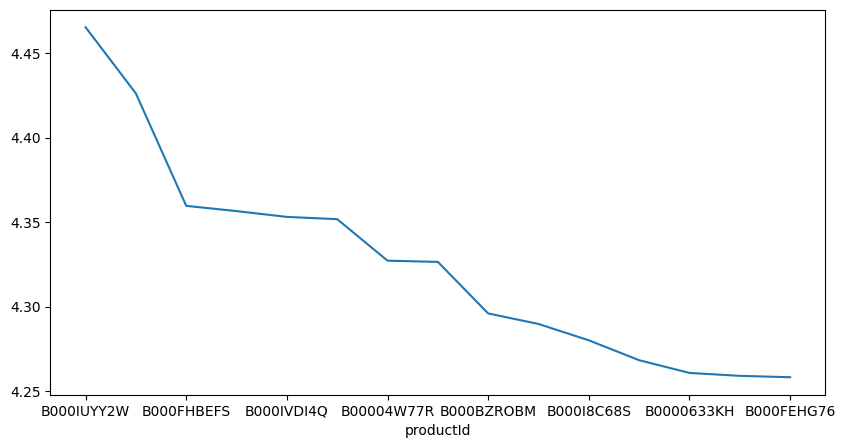

In [ ]:
import matplotlib.pyplot as plt

best = ratings.sort_values(ascending=False)
ax1 = best.head(15).plot()

ax1.get_figure().set_size_inches(10, 5)

print(ratings.sort_values(ascending=False).head())
plt.show()


Display users with the highest amount of ratings

In [ ]:
cor_mat[user_cols].count(axis=0).sort_values(ascending=False).head()

userId
A1RCGK44YXNBBB    25
A33FS5H3CPDR6D    18
A2C8IPPOF90CJG    17
A5JLAU2ARJ0BO     15
A3ILVGZSKUCC5Z    15
dtype: int64

Let's recommend products for user A5JLAU2ARJ0BO 

In [ ]:
user = 'A5JLAU2ARJ0BO'
user_ratings = cor_mat[user]
similiar_users = cor_mat.corrwith(user_ratings)
similiar_users.sort_values(ascending=False).head()

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


userId
A5JLAU2ARJ0BO            1.0
A1TNG2A1GAG14B           1.0
A149RNR5RH19YY          -0.5
A0178368ZY3E7X30LQOA     NaN
A04650352LYYBQ1TZF1L3    NaN
dtype: float64

Not enough user ratings for a recommendation system.



### Second method

Let's chose a product and find users who have rated it.

In [ ]:
cor_mat_p = cor_mat.transpose()
cor_mat_p.head()

product_cols = []
for col in cor_mat_p.columns.values:
        product_cols.append(col)

prod_count = pd.DataFrame(cor_mat_p[product_cols].count(axis=0).sort_values(ascending=False))
prod_count.columns = ['count']
prod_count.head()

,count
productId,
B0009B0IX4,3436
B0007WWAGI,981
B000GAO9T2,843
B000CQXHOS,625
B000RUPEOA,621


Let's look for products with similiar ratings

In [ ]:
product = 'B0007WWAGI'
correlated_products = pd.DataFrame()
product_ratings = cor_mat_p[product]
correlated_products['correlation'] = pd.DataFrame(cor_mat_p.corrwith(product_ratings))
correlated_products.drop(product, axis = 0, inplace=True)
correlated_products.sort_values(ascending=False, by='correlation').head()

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,correlation
productId,
B0007XY66O,1.0
B0002WRGH6,1.0
B000ARU12A,1.0
B0006JLKUY,1.0
B0002W2H2K,1.0


Some of the products are seen as highly correlated, however they may have a low number of votes. Correlated products with less than 50 ratings will not be recommended.

In [ ]:
correlated_products = pd.concat([correlated_products, prod_count], axis=1)
correlated_products.drop(correlated_products[correlated_products['count'] < 50].index, inplace=True)

correlated_products.sort_values(by=['correlation', 'count'], ascending=[False, False]).head(10)

,correlation,count
productId,,
B0002WRGH6,1.000000,324
B0002W2H2K,1.000000,127
B0007XY66O,1.000000,81
B0007N08NO,0.886405,342
B0002WRGHG,0.708010,377
B000CQXHOS,0.700649,625
B0006HTZ80,0.500000,407
B0009B0IX4,0.133461,3436
B000JKKE5M,-0.277350,505


In [ ]:
#!pip install transformers
!pip install datasets
!pip install evaluate